In [1]:
#clone repo,make scripts usable for this user,get dependencies
LOADED=True
import os,sys,pickle
!pip install seaborn
if not LOADED:
    
    os.system(r"git clone https://github.com/1795757/csl/")
    os.system(r"chmod u+x csl/getdependencies.sh")
    os.system(r"!csl/getdependencies.sh")

#data
import pandas as pd
import numpy as np

#visual
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

import time
import csl.utils

import csl.unpack_format as unpack_format
import csl.Image_Datasets as Images_Datasets

from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.io import read_image
import torchvision.models as models
#from torchvision.models import ResNet50_Weights
import torchvision.transforms

import torch
from torch.utils.data import Dataset
import torch.optim as optim
from torch.utils.data import DataLoader
from torch import nn

from sklearn.model_selection import train_test_split


import functools
from PIL import Image
RANDOM_STATE=1
import pandas as pd
import pickle
import requests,os

In [2]:
hflip=torchvision.transforms.RandomHorizontalFlip()#50%
vlip=torchvision.transforms.RandomVerticalFlip()#50%
jitter=torchvision.transforms.ColorJitter()
def add_augments_helper(element):
  if element is None:
    return [hflip,vlip,jitter],[]
  else:
    if type(element) is float:
        print(element)
    return [*element[0],hflip,vlip,jitter],[*element[1]]
def add_augments(df:pd.DataFrame,class_thresholds:dict,modification_ratio:float):
  for category,target in class_thresholds.items():
    target*=len(df)
    incat=df[df['category_id']==category]#instances in category
    #the number of entries to be added
    if len(incat)<target:
        
      sample=incat.sample(int(target-len(incat)),random_state=RANDOM_STATE)
      sample.index=sample.reindex(tuple((*i[:-1],True) for i in sample.index)).index
      sample['transforms']=sample['transforms'].apply(add_augments_helper)
      df=pd.concat([df,sample])


    #number of entries to be modified
    if int(target*modification_ratio+0.5)>0:
        sample=incat.sample(int(target*modification_ratio+0.5),random_state=RANDOM_STATE+1)
        df.loc[sample.index]['transforms']=df[sample.index]['transforms'].apply(add_augments_helper)
  return df

In [3]:
def subsample(df,class_thresholds:dict):#subsampling without taking cameras into account
    return pd.concat([df[df['category_id']==c].sample(int(t*len(df)),random_state=RANDOM_STATE+2) for c,t in class_thresholds.items()])
def toLabel(element,length=1):
  ret=torch.zeros(length)
  ret[convert_category_id[element]]=1
  return ret


In [5]:

def to_dataframe_coco(name,name_abbrev,format_unpacker=unpack_format.snapshot_safari_paths_from_name):

    datapath,cameras,metadata,mega_A,mega_B=format_unpacker(name,name_abbrev)
    if name=='kgalagadi':#typo in filename
        metadata='SnapshotKgalagadi_S1_v1.0.json/SnapshotKgalagai_S1_v1.0.json'
    camera_index_in_path=1
    category_not_included=1
    #unpack provided metadata
    info,categories,annotations=unpack_format.unpack_coco(f'{datapath}{metadata}')#unpack json formatted annotations
    #TODO add json path in csl/datasets.csv
    y={k:v['category_id'] for k,v in annotations.items()}
    id_to_name={e["id"]:e["name"]for e in categories} 
    name_to_id={e["name"]:e["id"]for e in categories} 
    #In the snapshot-kgalagadi dataset humans have category_id 1 but are not included in the public images dataset
    #all images with category_id == 1 are dropped
    raw_df=pd.DataFrame.from_dict(annotations,orient="index")
    raw_df=raw_df[raw_df["category_id"]!=category_not_included]
    raw_df=raw_df[raw_df["corrupt"]==False]
    #given raw_df.index[i].split("/") the index where the camera location is encoded in the format [A-Z]+[0-9][0-9]+
    raw_df['camera']=pd.Series(raw_df.index,raw_df.index).apply(lambda s:s.split("/")[camera_index_in_path])
    if (len(raw_df['width'].unique())==1) and (len(raw_df['height'].unique())==1):
      WIDTH,HEIGHT=raw_df['width'].iloc[0],raw_df['height'].iloc[0]
    else:
      WIDTH,HEIGHT=None,None
    df=raw_df[["category_id","file_name","camera"]]#remove unused metadata
    df=unpack_format.unpack_mega(f"{datapath}{mega_A}",df_imgs=df,WIDTH=WIDTH,HEIGHT=HEIGHT)

    threshold=.01
    val_counts=pd.DataFrame(df["category_id"].value_counts())
    val_counts.rename(columns={"category_id":"counts"},inplace=True)
    val_counts["ratio"]=val_counts["counts"]/len(df)
    if type(threshold) is float:
      above_threshold=val_counts[val_counts["ratio"]>threshold].index
    if type(threshold) is int:
     above_threshold=val_counts[val_counts["counts"]>threshold].index
    #remove categories below threshold
    original_categories=df["category_id"].unique()
    preremoval_len=len(df)
    df=df[df["category_id"].isin(above_threshold)]
    cur_categories=df["category_id"].unique()
    id_to_name={e["id"]:e["name"]for e in categories} 
    name_to_id={e["name"]:e["id"]for e in categories} 
    removed_categories=list(set(original_categories)-set(cur_categories))
    convertLabel={x:i for i,x in enumerate(cur_categories)}
    #output of model should be of length category id 
    df=df.reindex(tuple((*i,False) for i in df.index))
    threshold*=preremoval_len/len(df)
    threshold,df['category_id'].value_counts()/len(df)
    df['transforms']=None
    target_values=(df['category_id'].value_counts()/len(df)).min()*1.5
    preaugmentlen=len(df)
    df=add_augments(df,{c:target_values for c in cur_categories},0)
    presubsamplelen=len(df)
    df=subsample(df,{c:target_values*preaugmentlen/len(df) for c in cur_categories})
    return df



enonkishu


In [ ]:
name='enonkishu'
name_abbrev='ENO'
df=to_dataframe_coco(name,name_abbrev)
with open(f'{name}_df.pkl','wb') as file:
        pickle.dump(df,file)
print(name)

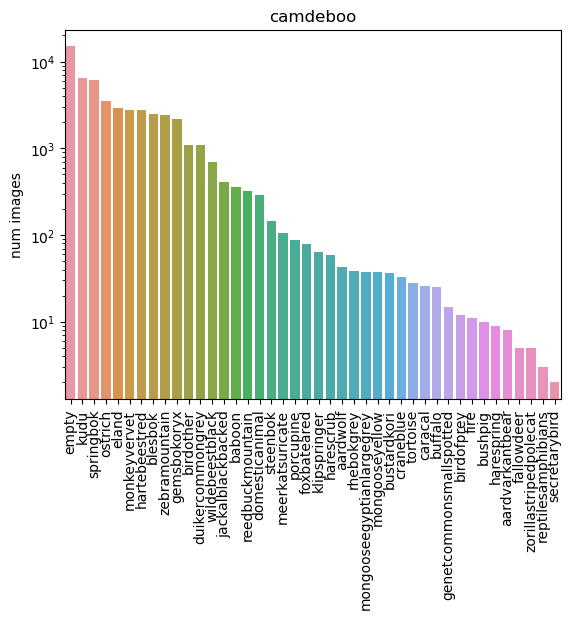

In [39]:
#class distribution visualization
val_counts=df['category_id'].value_counts()
fig,ax=plt.subplots()
sns.barplot(x=val_counts.index.map(id_to_name.__getitem__),y=val_counts,ax=ax)
plt.yscale("log")
plt.xticks(rotation=90)
plt.ylabel('num images')
plt.title(name)
plt.show()


In [2]:
import os,shutil
def ignore_files(dirname,lsdir):
  return [f for f in lsdir if os.path.isfile(f) or f.startswith(".") or f.endswith(".JPG")]
def copy_folder_structure_kaggle(datapath,cameras,name):
  shutil.copytree(f'{datapath}{cameras}',f"{name}-processed",ignore=ignore_files)


In [10]:
resnet50_pre_transforms=[torchvision.transforms.Resize(size=(224,224))]
resnet50_post_transforms=[torchvision.transforms.Normalize(
                    mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)#bc trained on imagenet
                )]

In [ ]:
datapath,cameras,metadata,mega_A,mega_B=format_unpacker(name,name_abbrev)
copy_folder_structure_kaggle(datapath,cameras,name)
ds=Images_Dataset_SAVE(df
,file_extension="pt"
,file_path=f'{datapath}{cameras}'
,pretensor_transforms_all=resnet50_pre_transforms
,posttensor_transforms_all=resnet50_post_transforms)